## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Show example image

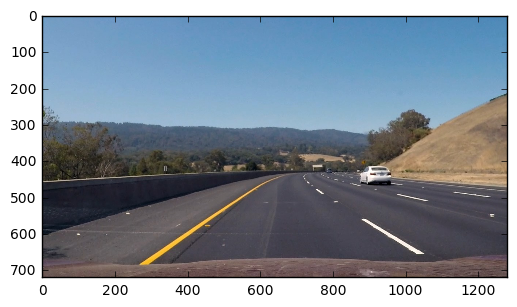

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

from project import *

mtx, dist = load_cal_matrix()

test_image = "test_images/test3.jpg"
image = cv2.imread(test_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

## Undistort

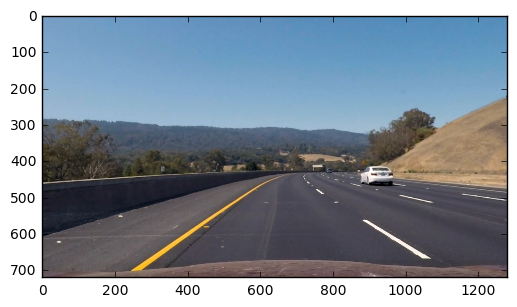

In [5]:
undistorted = cv2.undistort(image, mtx, dist, None, mtx)

plt.imshow(undistorted)


## Create thresholded binary image

Apply color transform and threshold values

In [30]:
thresh=(170, 255)

hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
s_channel = hls[:, :, 2]
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1

Extract gradient using sobel operator and threshold values

In [31]:
thresh=(20, 100)

gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
# Rescale back to 8 bit integer
scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
# Create a copy and apply the threshold
gradient_binary = np.zeros_like(scaled_sobel)
gradient_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

Combine binary images

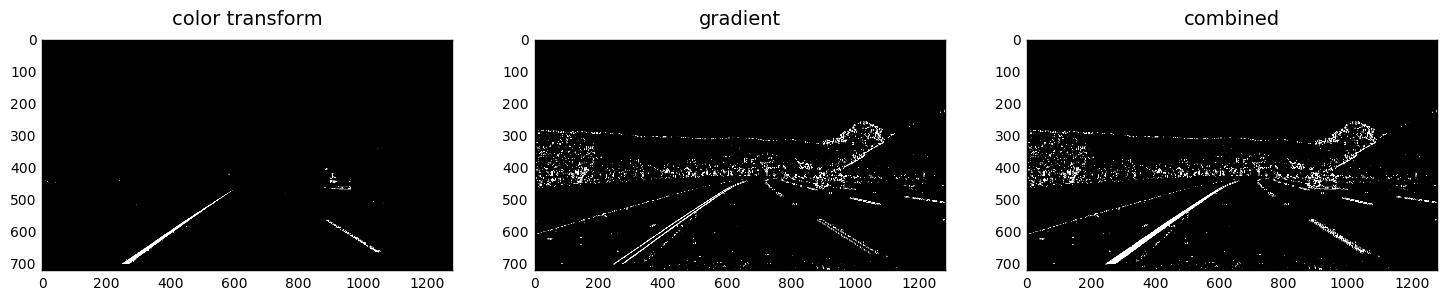

In [37]:
combined_binary = np.zeros_like(s_binary)
combined_binary[(s_binary == 1) | (binary_output == 1)] = 1

show_images(s_binary, gradient_binary, combined_binary, title=["color transform", "gradient", "combined"])

## Perspective transformation

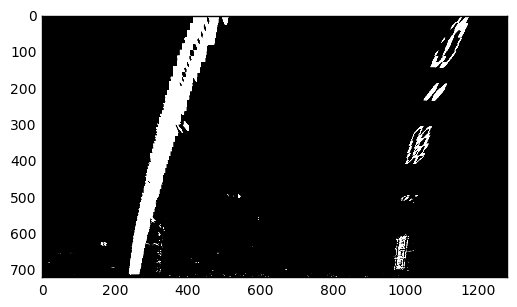

In [40]:
src = np.float32([[220, 719], [1220, 719], [750, 477], [553, 480]])    
dst = np.float32([[240, 719], [1040, 719], [1040, 300], [240, 300]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

bird_eye_view = cv2.warpPerspective(combined_binary, M, (1280, 720), flags=cv2.INTER_LINEAR)
plt.imshow(bird_eye_view, cmap='gray')

## Lane points

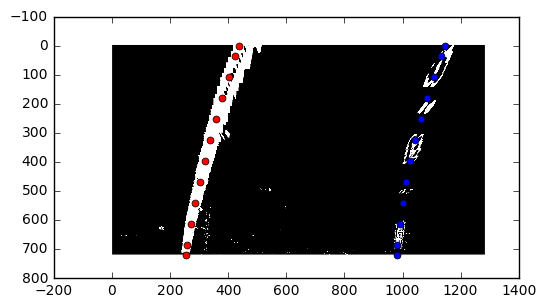

In [41]:
h, w = bird_eye_view.shape
split = w // 2
window_h = h // stripes

lp_x = []
lp_y = []
rp_x = []
rp_y = []

histogram = np.sum(bird_eye_view[h // 2:, :], axis=0)
left_lane_hist = histogram[:split]
right_lane_hist = histogram[split:]

peaks_left = ndimage.measurements.center_of_mass(left_lane_hist)
prev_lx = int(peaks_left[0]) if peaks_left else None

peaks_right = ndimage.measurements.center_of_mass(right_lane_hist)
prev_rx = (split + int(peaks_right[0])) if peaks_right else None

for bottom_y in range(h, 0, -window_h):

    win_top = bottom_y - window_h
    win_bottom = bottom_y

    if prev_lx:
        win_l_left = prev_lx - window_half_w
        win_l_right = prev_lx + window_half_w
        window_l = bird_eye_view[win_top:win_bottom, win_l_left:win_l_right]

        pix = np.sum(window_l)

        if pix > min_pixels:
            hist_left = np.sum(window_l, axis=0)
            peaks = ndimage.measurements.center_of_mass(hist_left)[0]
            if not np.isnan(peaks):
                lp_x.append(win_l_left + int(peaks))
                lp_y.append(bottom_y - window_h // 2)
                prev_lx = win_l_left + int(peaks)

    if prev_rx:
        win_r_left = prev_rx - window_half_w
        win_r_right = prev_rx + window_half_w
        window_r = bird_eye_view[win_top:win_bottom, win_r_left:win_r_right]

        pix = np.sum(window_r)

        if pix > min_pixels:
            hist_right = np.sum(window_r, axis=0)
            peaks = ndimage.measurements.center_of_mass(hist_right)[0]
            if not np.isnan(peaks):
                rp_x.append(win_r_left + int(peaks))
                rp_y.append(bottom_y - window_h // 2)
                prev_rx = win_r_left + int(peaks)

lp_x = np.array(lp_x[::-1])
lp_y = np.array(lp_y[::-1])
rp_x = np.array(rp_x[::-1])
rp_y = np.array(rp_y[::-1])

left_fit = np.polyfit(lp_y, lp_x, 2)
right_fit = np.polyfit(rp_y, rp_x, 2)
left_fitx = x(left_fit[0], left_fit[1], left_fit[2], lp_y)
right_fitx = x(right_fit[0], right_fit[1], right_fit[2], rp_y)
lastx_l = left_fit[2]
lastx_r = right_fit[2]
firstx_l = x(left_fit[0], left_fit[1], left_fit[2], h-1)
firstx_r = x(right_fit[0], right_fit[1], right_fit[2], h-1)
lp_y = np.hstack(([0], lp_y, [(h-1)]))
rp_y = np.hstack(([0], rp_y, [(h-1)]))
left_fitx = np.hstack(([lastx_l], left_fitx, [firstx_l]))
right_fitx = np.hstack(([lastx_r], right_fitx, [firstx_r]))
    
f, axes = plt.subplots(1, 1, squeeze=False)
f.set_size_inches((6, 8))
img = bird_eye_view
ax = axes[0][0]
if len(img.shape) == 3:
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
else:
    ax.imshow(img, cmap="gray")
    
ax.plot(left_fitx, lp_y, 'o', color='red', markersize=5)
ax.plot(right_fitx, rp_y, 'o', color='blue', markersize=5)    

## Calculate curvature

In [45]:
y_eval = 350
ym_per_pix = 30/720     # meters per pixel in y dimension
xm_per_pix = 3.7/700    # meters per pixel in x dimension

def curv(coef1, coef2, y):
    return ((1 + (2 * coef1 * y * ym_per_pix + coef2) ** 2) ** 1.5) / np.absolute(2 * coef1)

left_fit_cr = np.polyfit(lp_y * ym_per_pix, left_fitx * xm_per_pix, 2)
right_fit_cr = np.polyfit(rp_y * ym_per_pix, right_fitx * xm_per_pix, 2)

left_curverad = curv(left_fit_cr[0], left_fit_cr[1], y_eval)
right_curverad = curv(right_fit_cr[0], right_fit_cr[1], y_eval)

print("Estimated curvature: Left: {0}m".format(round(left_curverad, 2)))
print("Estimated curvature: Right: {0}m".format(round(right_curverad, 2)))

Estimated curvature: Left: 1372.66m
Estimated curvature: Right: 765.51m


## Result plotted back down onto the road

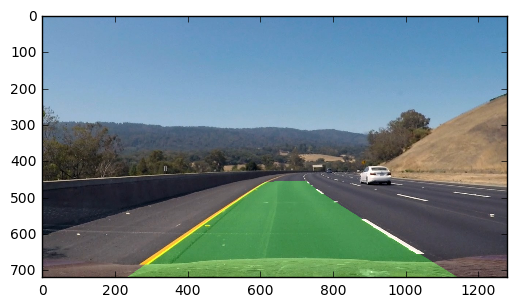

In [46]:
warp_zero = np.zeros_like(bird_eye_view).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usableformat for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, np.array(lp_y, dtype=np.float64)]))])
pts_right = np.array(
        [np.flipud(np.transpose(np.vstack([right_fitx, np.array(rp_y, dtype=np.float64)])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int32(pts), (0, 255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

plt.imshow(result)